In [1]:
%pip install opencv-python
%pip install joblib
%pip install pandas
%pip install numpy
%pip install sklearn
%pip install matplotlib
%pip install seaborn

import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import cv2
import pandas as pd
#Note: doing import matplotlib as plt dosen't work for some reason
# ***: Either environment or namespacing issue
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
#load in test image.
#Note, on windows: Use foward slash
img = cv2.imread('./test_images/Musk1.jpg')
img.shape

#(x,y,RGB channels)

(2609, 2609, 3)

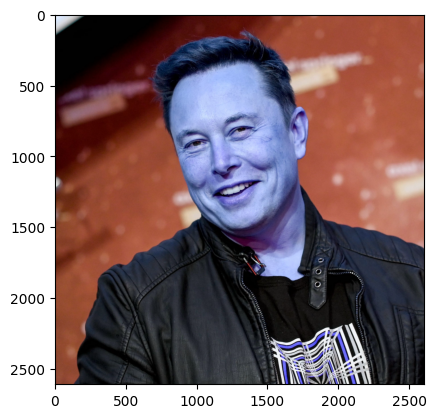

In [4]:
plt.imshow(img)

In [5]:
#We can change the RGB to Grayscale:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [6]:
#outputs a bunch of digits indicating the 'dark' value of pixels
gray 

array([[239, 239, 239, ...,  88,  88,  88],
       [239, 239, 239, ...,  88,  87,  87],
       [239, 239, 239, ...,  87,  87,  88],
       ...,
       [ 68,  69,  68, ...,   1,   1,   1],
       [ 64,  68,  71, ...,   1,   1,   1],
       [ 67,  68,  69, ...,   1,   1,   1]], dtype=uint8)

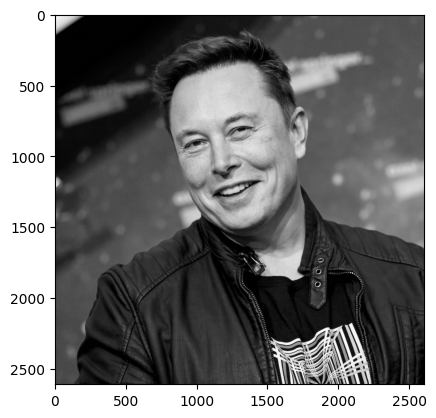

In [7]:
plt.imshow(gray, cmap='gray')

### Face Detection using Harr Cascades
General idea: Line and Edge features using moving windows to detect facial features using 'shadows'

Downloaded harr cascades from CV github, shown as opencv folder: helps detect different features of the face
All pretrained classifiers 

In [8]:
#We open these classifiers, get to see how these work
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

#returns an array of face arrays -> (x,y,width,height)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[ 647,  418, 1079, 1079]])

In [9]:
#we store these values
(x,y,w,h) = faces[0]
x,y,w,h

(647, 418, 1079, 1079)

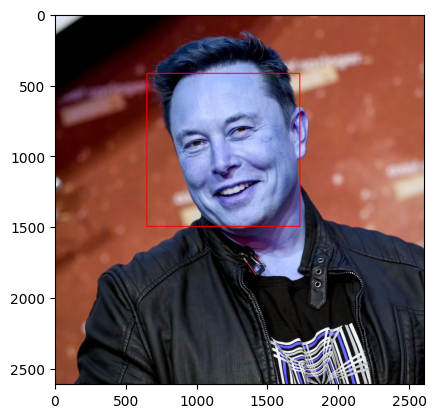

In [10]:
#now lets draw the face rectangle over the image using opencv
#img,start at x,y, dimensions, (R,G,B), pixel width
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),5)
plt.imshow(face_img)

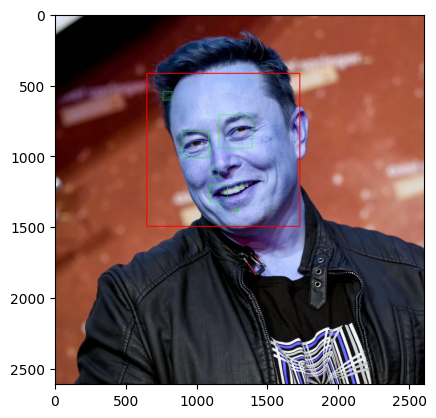

In [11]:
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')
cv2.destroyAllWindows()

#iterate through all the faces
#return our regions of interests (roi)
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)   
    roi_gray = gray[y:y+h, x:x+w]         
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)   #apply eye cascades
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)  #apply rectangles in green

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

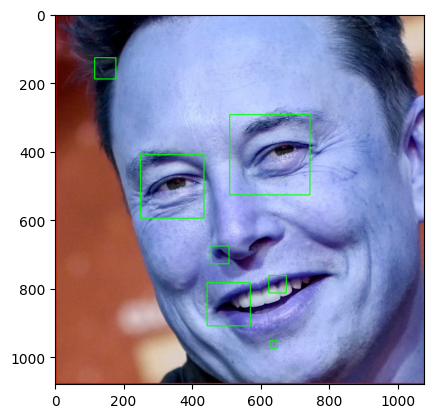

In [12]:
#we will be cropping all the face images as those are our area of interest
#not the best image as cascade has detected 7 eyes, so we will address that later
plt.imshow(roi_color,cmap='gray')

In [13]:
#Let's create a function that takes all these images and crops as well
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          #turn to grayscale
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)   #detect the faces
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)     #detect the eyes
        if len(eyes) >= 2:                                #if more than 2 eyes, return it since we know theres a face
            return roi_color

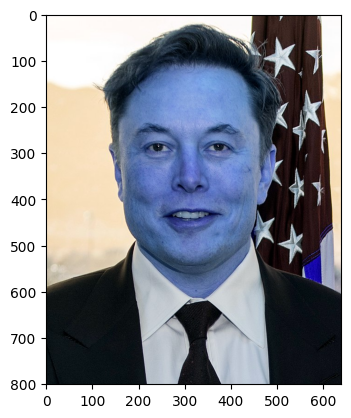

In [14]:
image_1 = cv2.imread('./test_images/Musk2.jpg')
plt.imshow(image_1)

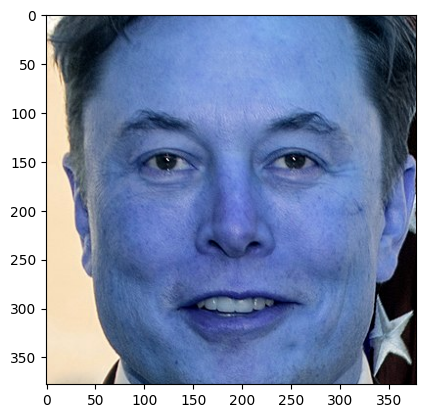

In [15]:
cropped_img_1 = get_cropped_image_if_2_eyes('./test_images/Musk2.jpg')
plt.imshow(cropped_img_1)

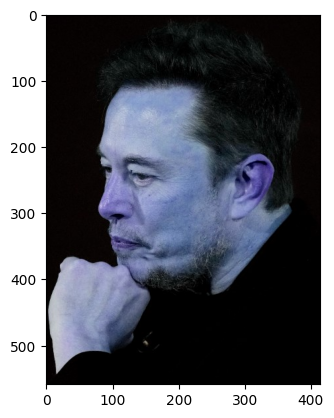

In [16]:
#Let's try a 3rd image, but Musk in this one dosen't have fully visible eyes
bad_image3 = cv2.imread('./test_images/Musk3.jpg')
plt.imshow(bad_image3)

In [17]:
cropped_img_3 = get_cropped_image_if_2_eyes('./test_images/Musk3.jpg')
cropped_img_3  #no output give only 1 eye is visible

## Now let's start the data cleaning process
#

In [18]:
#Alright, Let's create a cropped folder where we put all of out cropped dataset
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [19]:
import os
#we store the names of each directory into directory list
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [20]:
img_dirs

['./dataset/001_Elon_Musk',
 './dataset/002_Bernard_Arnault',
 './dataset/003_Jeff_Bezos',
 './dataset/004_Larry_Ellison',
 './dataset/006_Bill_Gates',
 './dataset/cropped']

In [21]:
#create a cropped folder if it dosen't exist
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
#Put Cropped images into folder
cropped_image_dirs = []
celebrity_file_names_dict = {}   #Contains dictionary of all cropped images to their right faces

for img_dir in img_dirs:
    count = 0
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        try:  #Sometimes image is not processable, error handle it
              #Check if image has more than 2 eyes to work with
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                # Process Good Image
                cropped_folder = path_to_cr_data + celebrity_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
                cropped_file_name = celebrity_name + str(count) + ".png"
                cropped_file_path = cropped_folder + "/" + cropped_file_name
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1
        #output where error has occured as well
        except Exception as e:
            print(f"An error occurred while processing file {entry.path}: {e}")
            continue


Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk


Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
Generating cropped images in folder:  ./dataset/cropped/001_Elon_Musk
An error occurred while processing file ./dataset/001_Elon_Musk\aaca42e2-c15f-4ff4-be00-d377d90384d4.txt: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\

#### Still need to do a manual check to see if other faces are in the folders
- After we remove them, we need to update our dictionary with new values

In [32]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'001_Elon_Musk': ['./dataset/cropped/001_Elon_Musk\\001_Elon_Musk0.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk1.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk10.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk11.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk12.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk13.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk14.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk15.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk16.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk17.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk18.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk19.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk2.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk20.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk21.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk22.png',
  './dataset/cropped/001_Elon_Musk\\001_Elon_Musk23.png',


In [34]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'001_Elon_Musk': 0,
 '002_Bernard_Arnault': 1,
 '003_Jeff_Bezos': 2,
 '004_Larry_Ellison': 3,
 '006_Bill_Gates': 4}

### Feature Engineering (via Wavelet)
- We will seperate x and y datasets to train our model
- We will perform a wavelet transformation on our images -> Extract important features from our images
- wavelet transformed images gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

In [42]:
#Have no clue how the math works here, but credit to codeBasics for crediting StackOverflow

import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

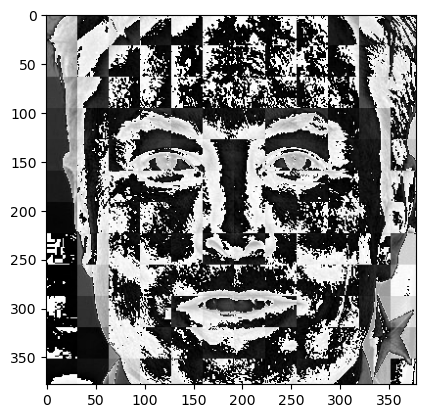

In [36]:
#We are extracting the important facial features
im_har = w2d(cropped_img_1,'db1',5)
plt.imshow(im_har, cmap='gray')

#### Idea behind wavelit transformations: Signal Processing
How Images are represented as a frequency. Can be presented in two types of domains:
- Spatial Domain: Space
- Frequency Domain

Fourier Transform: Takes a complex signal and returns basic signal that makes up that complex signal. Seperate out voices...
- https://www.youtube.com/watch?v=spUNpyF58BY&t=423s
- Noise Cancellation?

#### Using wavelet, we can extract these raw data from our cropped images:
- Idea is that we're stacking our RGB image on top of wavelet transformed ones

In [37]:
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [38]:
len(X[0])

4096

In [39]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(171, 4096)

### Finally... Time to train our model!

In [40]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe = Pipeline([('scalar', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC(C=10))])

In [42]:
pipe.score(X_test, y_test)

0.6976744186046512

In [43]:
len(X_test)  #we tested it on 43 images and it did atrocious

43

#### Ok, let's do a classification report
Main Vocabulary
- Precision: what % are we making right/relevant out of entire section?
- Recall: what % of right/relevant out of their correct set?
- F1 Score: Score around precision and recall

In [44]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.57      1.00      0.72        13
           1       1.00      0.38      0.55         8
           2       0.67      0.75      0.71         8
           3       1.00      0.50      0.67        10
           4       1.00      0.75      0.86         4

    accuracy                           0.70        43
   macro avg       0.85      0.68      0.70        43
weighted avg       0.81      0.70      0.69        43



#### Use Gridsearch to try out different models with different parameters via Hyper parameter testing

In [45]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV  

In [46]:
#dictionary of different models to try with these parameters
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],         #svm with 1,10,100,1000
            'svc__kernel': ['rbf','linear']    #kernel being rbf or linear
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]  
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [47]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():      #for every model
    pipe = make_pipeline(StandardScaler(), mp['model'])               #sk learn pipeline (scale -> train)
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)    #train, test, validation data
    scores.append({         #append scores into a list, with their best parameters
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])  
df

,model,best_score,best_params
0,svm,0.539692,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.374462,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.546462,{'logisticregression__C': 1}


In [48]:
best_estimators        #Contains best parameters via hyperparameter testing

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [49]:
best_estimators['svm'].score(X_test,y_test)

0.7209302325581395

In [50]:
best_estimators['random_forest'].score(X_test,y_test)

0.5116279069767442

In [51]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.813953488372093

#### Now that we've decided to use which model, we use a confusion matrix to see our data set

In [52]:
from sklearn.metrics import confusion_matrix

best_model = best_estimators['logistic_regression']
cm = confusion_matrix(y_test, best_model.predict(X_test))


Text(95.72222222222221, 0.5, 'Actual')

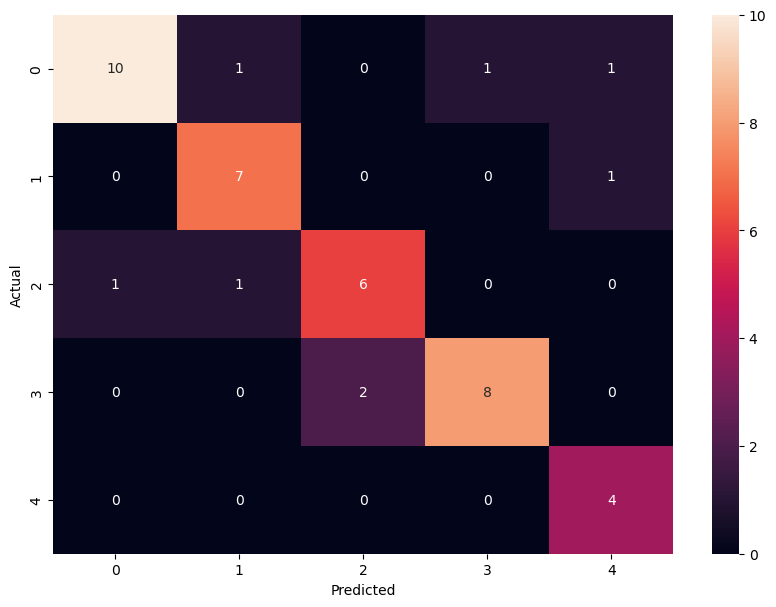

In [53]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [54]:
class_dict

{'001_Elon_Musk': 0,
 '002_Bernard_Arnault': 1,
 '003_Jeff_Bezos': 2,
 '004_Larry_Ellison': 3,
 '006_Bill_Gates': 4}

#### Alright, now that we've created our model, let's save our trained model

In [55]:
import joblib
joblib.dump(best_model, 'saved_model.pkl')

['saved_model.pkl']

#### Save our class Dictionary for later

In [56]:
#We will also save our class dictionary for python flask later
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

In [223]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: c:\Users\Andre\Desktop\ML_Projects\00_RichPeopleClassification_Project\model
